# import packages

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pickle5 as pickle
from scipy.stats import ranksums

def sort_cnt(arr):
    npcnt=np.array(np.unique(arr,return_counts=True)).T
    dfcnt=pd.DataFrame(npcnt)
    dfcnt[1]=dfcnt[1].astype('int')
    dfcnt=dfcnt.sort_values(by=1,ascending=False)
    return dfcnt

ModuleNotFoundError: No module named 'pickle5'

# Fix Meta Data

In [2]:
mydir='/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run1/'
folds=sorted(os.listdir(mydir))
#print(folds[i])

aa=pd.read_table('AML_cohort.txt',header=None)
aa=aa.values.reshape(28,2)
aa=pd.DataFrame(aa)
aa[1]='Hashtag'+aa[1]

In [514]:
BCR_folds=sorted(os.listdir(f'{mydir}BCR'))
TCR_folds=sorted(os.listdir(f'{mydir}TCR'))
RNA_folds=sorted(os.listdir(f'{mydir}RNA'))

In [515]:
RNA_pools=[]
TCR_pools=[]
BCR_pools=[]
KMA=[]
for i in range(7):
    BCR_pools.extend([BCR_folds[i]]*4)
    RNA_pools.extend([RNA_folds[i]]*4)
    TCR_pools.extend([TCR_folds[i]]*4)
    KMA.extend(['KMA'+str(i+1)]*4)
    

In [516]:
aa.columns=['sample','Hashtag']

aa['BCR_pool']=BCR_pools
aa['TCR_pool']=TCR_pools
aa['RNA_pool']=RNA_pools

In [517]:
import pickle5 as pickle
with open('umap_updated_withcontrols.pkl', "rb") as fh:
    meta = pickle.load(fh)

In [518]:
meta=meta.reset_index()

In [519]:
meta['pool_kma']=meta['index'].apply(lambda x: x.split('_')[0])
meta['barcode']=meta['index'].apply(lambda x: x.split('_')[1])

meta = meta[meta.dataset.isin(['dli','aml1'])].copy() #.dataset.value_counts()

pmap_dli={'p24_': 'AM_', 'p25_': 'AH_'}

meta['sample']=meta['sample'].apply(lambda x: pmap_dli[x] if x in pmap_dli.keys() else x)

meta['patient']=meta['sample'].apply(lambda x: x[:2])

meta['sample']=meta['sample'].apply(lambda x: x[:-1])

meta = meta[meta.patient!='EE'].copy()

In [520]:
meta.patient.value_counts()

LB    18178
EL    12840
KC    12707
MS    12121
AH    11459
JS    10365
GD     3174
AM     3057
Name: patient, dtype: int64

In [521]:
meta['time']=meta['time'].apply(lambda x: x if x in ['PRE','POST'] else 'DLI')

pat_res = dict(zip(meta[meta.time!='DLI'].patient,meta[meta.time!='DLI'].response))

meta['response']=meta['patient'].apply(lambda x: pat_res[x])

meta['sample']=meta['sample'].astype('str') # to remove categories

In [522]:
counts=pd.DataFrame(meta['sample'].value_counts())
counts=counts.reset_index()
counts.columns=['sample','cell_count']

In [523]:
counts

,sample,cell_count
0,MS,8683
1,JS,8669
2,AH,7585
3,EL,6544
4,LB1,5963
5,KC,5941
6,LB4,3808
7,LB,3684
8,AH2,3457
9,EL2,2964


In [524]:
final_tab=pd.merge(aa,counts,on='sample',how='left')
final_tab

,sample,Hashtag,BCR_pool,TCR_pool,RNA_pool,cell_count
0,LB1,Hashtag5,Pool118_15,Pool97_60,Pool97_23,5963.0
1,EL1,Hashtag6,Pool118_15,Pool97_60,Pool97_23,299.0
2,GD1,Hashtag7,Pool118_15,Pool97_60,Pool97_23,2068.0
3,JS1,Hashtag8,Pool118_15,Pool97_60,Pool97_23,870.0
4,LB2,Hashtag5,Pool118_16,Pool97_61,Pool97_24,1463.0
5,EL2,Hashtag6,Pool118_16,Pool97_61,Pool97_24,2964.0
6,GD2,Hashtag7,Pool118_16,Pool97_61,Pool97_24,649.0
7,AH1,Hashtag8,Pool118_16,Pool97_61,Pool97_24,273.0
8,AM1,Hashtag5,Pool118_17,Pool97_62,Pool97_25,244.0
9,LB3,Hashtag6,Pool118_17,Pool97_62,Pool97_25,1435.0


In [525]:
rna_map=dict(zip(final_tab['sample'],final_tab['RNA_pool']))
tcr_map=dict(zip(final_tab['sample'],final_tab['TCR_pool']))
bcr_map=dict(zip(final_tab['sample'],final_tab['BCR_pool']))
meta['barcode']=meta['barcode']+'-1'
meta['RNA_pool']=meta['sample'].apply(lambda x: rna_map[x] if x in rna_map.keys() else x)
meta['TCR_pool']=meta['sample'].apply(lambda x: tcr_map[x] if x in tcr_map.keys() else x)
meta['BCR_pool']=meta['sample'].apply(lambda x: bcr_map[x] if x in bcr_map.keys() else x)

In [526]:
meta

,index,x,y,sample,cluster_number,dataset,patient,time,response,pool_kma,barcode,RNA_pool,TCR_pool,BCR_pool
0,KMA1_AAACCTGAGAGGTTAT,11.877133,-4.378096,GD1,8,aml1,GD,PRE,NONRESPONDER,KMA1,AAACCTGAGAGGTTAT-1,Pool97_23,Pool97_60,Pool118_15
1,KMA1_AAACCTGAGGAGCGTT,11.945880,-5.867986,EL1,8,aml1,EL,PRE,RESPONDER,KMA1,AAACCTGAGGAGCGTT-1,Pool97_23,Pool97_60,Pool118_15
2,KMA1_AAACCTGAGGATTCGG,0.246520,-2.401615,LB1,1,aml1,LB,POST,RESPONDER,KMA1,AAACCTGAGGATTCGG-1,Pool97_23,Pool97_60,Pool118_15
3,KMA1_AAACCTGAGTCCTCCT,-2.495751,-0.160841,LB1,0,aml1,LB,POST,RESPONDER,KMA1,AAACCTGAGTCCTCCT-1,Pool97_23,Pool97_60,Pool118_15
4,KMA1_AAACCTGCACCCAGTG,-1.632356,-5.798063,JS1,13,aml1,JS,PRE,NONRESPONDER,KMA1,AAACCTGCACCCAGTG-1,Pool97_23,Pool97_60,Pool118_15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422635,JS_TTTGTCATCACCTCGT,6.609217,2.271738,JS,39,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCACCTCGT-1,JS,JS,JS
422636,JS_TTTGTCATCGGCGCTA,4.193547,14.795277,JS,3,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCGGCGCTA-1,JS,JS,JS
422637,JS_TTTGTCATCGTTTATC,-0.221223,-4.711385,JS,1,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCGTTTATC-1,JS,JS,JS
422638,JS_TTTGTCATCTTAACCT,4.109912,15.675632,JS,3,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCTTAACCT-1,JS,JS,JS


In [527]:
meta.to_csv('meta_aml_dli.csv',index=None)

In [507]:
meta=pd.read_csv('meta_aml_dli.csv')

In [528]:
#meta.to_csv('AML1_meta.csv',index=None)

#mm=pd.read_csv('AML1_meta')#,index_col='barcode')

#T_map={0: 'TEMRA', 45: 'NK-like', 37: 'gd-like', 19:  'Act.', 31: 'Prolif.', 3: 'TPE', 17: 'TPE', 7: 'TTE'}
T_map={
0: 'TEMRA',
2: 'Naive_Helper_1',
5: 'TEM/TRM_1',
18: 'TCM',
21: 'NK-like',
25: 'TEM/TRM_2',
26: 'Naive_Helper_2',
28: 'MAIT',
40: 'TEM/TRM_3',
1: 'NK_1',
13:'NK_2',
36:'NK_3'}

# Merge RNA and TCR all 7 AML pools

In [529]:
adatas=[]
for i in range(7):
    
    print(f'{mydir}RNA/{RNA_folds[i]}/outs/filtered_feature_bc_matrix.h5.h5')
    adata = sc.read_10x_h5(f'{mydir}RNA/{RNA_folds[i]}/outs/filtered_feature_bc_matrix.h5', gex_only=False)
    adata.var_names_make_unique()
    adata = adata[:,adata.var.feature_types=='Gene Expression'].copy()
    adata.var = adata.var[[]].copy()
    adata.obs.index.name='barcode'
    
    sub_meta = meta[meta['RNA_pool']==RNA_folds[i]].copy()
    sub_meta.set_index('barcode',inplace=True)
    sub_meta = sub_meta[['x','y','cluster_number','patient','response','sample','time']].copy()
    adata=adata[sub_meta.index].copy()
    adata.obs=adata.obs.merge(sub_meta,on='barcode')
    
    contig=pd.read_csv(f'{mydir}TCR/{TCR_folds[i]}/outs/filtered_contig_annotations.csv')
    TRBs=contig[contig.chain=='TRB']
    mult=sort_cnt(TRBs.barcode)
    TRBs=TRBs[TRBs.barcode.isin(mult[mult[1]==1][0])]
    TRBs=TRBs[['barcode','cdr3']]
    TRBs=TRBs.set_index('barcode')
    adata.obs=adata.obs.merge(TRBs,on='barcode',how='left')
    adata=adata[adata.obs.cluster_number.isin(T_map.keys())].copy()
    adata.obs['T-subtype'] = adata.obs['cluster_number'].apply(lambda x: T_map[x])
    adatas.append(adata)

/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run1/RNA/Pool97_23/outs/filtered_feature_bc_matrix.h5.h5


/home/meb521/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run1/RNA/Pool97_24/outs/filtered_feature_bc_matrix.h5.h5
/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run1/RNA/Pool97_25/outs/filtered_feature_bc_matrix.h5.h5
/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run1/RNA/Pool97_26/outs/filtered_feature_bc_matrix.h5.h5
/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run1/RNA/Pool97_27/outs/filtered_feature_bc_matrix.h5.h5
/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run1/RNA/Pool97_28/outs/filtered_feature_bc_matrix.h5.h5
/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run1/RNA/Pool97_29/outs/filtered_feature_bc_matrix.h5.h5


# DLIs

In [548]:
mydir='/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI1/RNA/'
folds=sorted(os.listdir(mydir))
DLI_ID=['MS','LB','EL','KC','JS','EE']
id_DLI_map=dict(zip(folds,DLI_ID))
id_DLI_map

mydir='/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI1/'

BCR_folds=sorted(os.listdir(f'{mydir}BCR'))
TCR_folds=sorted(os.listdir(f'{mydir}TCR'))
RNA_folds=sorted(os.listdir(f'{mydir}RNA'))

In [531]:
meta=meta[meta.dataset=='dli'].copy()

In [549]:
rna_map=dict(zip(DLI_ID,RNA_folds))
tcr_map=dict(zip(DLI_ID,TCR_folds))
bcr_map=dict(zip(DLI_ID,BCR_folds))

In [550]:
rna_map

{'MS': 'Pool109_1',
 'LB': 'Pool109_2',
 'EL': 'Pool109_3',
 'KC': 'Pool109_4',
 'JS': 'Pool109_5',
 'EE': 'Pool109_6'}

In [551]:
meta['RNA_pool']=meta['sample'].apply(lambda x: rna_map[x] if x in rna_map.keys() else x)
meta['TCR_pool']=meta['sample'].apply(lambda x: tcr_map[x] if x in tcr_map.keys() else x)
meta['BCR_pool']=meta['sample'].apply(lambda x: bcr_map[x] if x in bcr_map.keys() else x)

In [552]:
meta

,index,x,y,sample,cluster_number,dataset,patient,time,response,pool_kma,barcode,RNA_pool,TCR_pool,BCR_pool
379076,p24_AAACCTGAGCTAGTTC,0.314366,4.397660,AM,18,dli,AM,DLI,NONRESPONDER,p24,AAACCTGAGCTAGTTC-1,AM,AM,AM
379077,p24_AAACCTGCAGACTCGC,0.893977,6.884057,AM,18,dli,AM,DLI,NONRESPONDER,p24,AAACCTGCAGACTCGC-1,AM,AM,AM
379078,p24_AAACCTGCATATGCTG,1.159320,3.522225,AM,26,dli,AM,DLI,NONRESPONDER,p24,AAACCTGCATATGCTG-1,AM,AM,AM
379079,p24_AAACCTGGTCACACGC,-0.261631,6.592393,AM,18,dli,AM,DLI,NONRESPONDER,p24,AAACCTGGTCACACGC-1,AM,AM,AM
379080,p24_AAACCTGGTCTGATTG,0.952912,7.001884,AM,18,dli,AM,DLI,NONRESPONDER,p24,AAACCTGGTCTGATTG-1,AM,AM,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422635,JS_TTTGTCATCACCTCGT,6.609217,2.271738,JS,39,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCACCTCGT-1,Pool109_5,Pool109_38,Pool119-72
422636,JS_TTTGTCATCGGCGCTA,4.193547,14.795277,JS,3,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCGGCGCTA-1,Pool109_5,Pool109_38,Pool119-72
422637,JS_TTTGTCATCGTTTATC,-0.221223,-4.711385,JS,1,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCGTTTATC-1,Pool109_5,Pool109_38,Pool119-72
422638,JS_TTTGTCATCTTAACCT,4.109912,15.675632,JS,3,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCTTAACCT-1,Pool109_5,Pool109_38,Pool119-72


In [553]:

adatas2=[]
for i in range(5):
    
    print(f'{mydir}RNA/{RNA_folds[i]}/outs/filtered_feature_bc_matrix.h5.h5')
    adata = sc.read_10x_h5(f'{mydir}RNA/{RNA_folds[i]}/outs/filtered_feature_bc_matrix.h5', gex_only=False)
    adata.var_names_make_unique()
    adata = adata[:,adata.var.feature_types=='Gene Expression'].copy()
    adata.var = adata.var[[]].copy()
    adata.obs.index.name='barcode'
    
    sub_meta = meta[meta['RNA_pool']==RNA_folds[i]].copy()
    sub_meta.set_index('barcode',inplace=True)
    sub_meta = sub_meta[['x','y','cluster_number','patient','response','sample','time']].copy()
    adata=adata[sub_meta.index].copy()
    adata.obs=adata.obs.merge(sub_meta,on='barcode')
    
    contig=pd.read_csv(f'{mydir}TCR/{TCR_folds[i]}/outs/filtered_contig_annotations.csv')
    TRBs=contig[contig.chain=='TRB']
    mult=sort_cnt(TRBs.barcode)
    TRBs=TRBs[TRBs.barcode.isin(mult[mult[1]==1][0])]
    TRBs=TRBs[['barcode','cdr3']]
    TRBs=TRBs.set_index('barcode')
    adata.obs=adata.obs.merge(TRBs,on='barcode',how='left')
    adata=adata[adata.obs.cluster_number.isin(T_map.keys())].copy()
    adata.obs['T-subtype'] = adata.obs['cluster_number'].apply(lambda x: T_map[x])
    adatas2.append(adata)

/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI1/RNA/Pool109_1/outs/filtered_feature_bc_matrix.h5.h5


/home/meb521/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI1/RNA/Pool109_2/outs/filtered_feature_bc_matrix.h5.h5
/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI1/RNA/Pool109_3/outs/filtered_feature_bc_matrix.h5.h5
/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI1/RNA/Pool109_4/outs/filtered_feature_bc_matrix.h5.h5
/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI1/RNA/Pool109_5/outs/filtered_feature_bc_matrix.h5.h5


In [554]:
mydir='/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI2/RNA/'
folds=sorted(os.listdir(mydir))
DLI_ID=['AM','AH']
id_DLI_map=dict(zip(folds,DLI_ID))
id_DLI_map

mydir='/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI2/'

BCR_folds=sorted(os.listdir(f'{mydir}BCR'))
TCR_folds=sorted(os.listdir(f'{mydir}TCR'))
RNA_folds=sorted(os.listdir(f'{mydir}RNA'))

In [555]:
rna_map=dict(zip(DLI_ID,RNA_folds))
tcr_map=dict(zip(DLI_ID,TCR_folds))
bcr_map=dict(zip(DLI_ID,BCR_folds))

In [556]:
rna_map

{'AM': 'Pool119-24', 'AH': 'Pool119-25'}

In [557]:

meta['RNA_pool']=meta['sample'].apply(lambda x: rna_map[x] if x in rna_map.keys() else x)
meta['TCR_pool']=meta['sample'].apply(lambda x: tcr_map[x] if x in tcr_map.keys() else x)
meta['BCR_pool']=meta['sample'].apply(lambda x: bcr_map[x] if x in bcr_map.keys() else x)

In [558]:
meta

,index,x,y,sample,cluster_number,dataset,patient,time,response,pool_kma,barcode,RNA_pool,TCR_pool,BCR_pool
379076,p24_AAACCTGAGCTAGTTC,0.314366,4.397660,AM,18,dli,AM,DLI,NONRESPONDER,p24,AAACCTGAGCTAGTTC-1,Pool119-24,Pool119-62,Pool119-74
379077,p24_AAACCTGCAGACTCGC,0.893977,6.884057,AM,18,dli,AM,DLI,NONRESPONDER,p24,AAACCTGCAGACTCGC-1,Pool119-24,Pool119-62,Pool119-74
379078,p24_AAACCTGCATATGCTG,1.159320,3.522225,AM,26,dli,AM,DLI,NONRESPONDER,p24,AAACCTGCATATGCTG-1,Pool119-24,Pool119-62,Pool119-74
379079,p24_AAACCTGGTCACACGC,-0.261631,6.592393,AM,18,dli,AM,DLI,NONRESPONDER,p24,AAACCTGGTCACACGC-1,Pool119-24,Pool119-62,Pool119-74
379080,p24_AAACCTGGTCTGATTG,0.952912,7.001884,AM,18,dli,AM,DLI,NONRESPONDER,p24,AAACCTGGTCTGATTG-1,Pool119-24,Pool119-62,Pool119-74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422635,JS_TTTGTCATCACCTCGT,6.609217,2.271738,JS,39,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCACCTCGT-1,JS,JS,JS
422636,JS_TTTGTCATCGGCGCTA,4.193547,14.795277,JS,3,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCGGCGCTA-1,JS,JS,JS
422637,JS_TTTGTCATCGTTTATC,-0.221223,-4.711385,JS,1,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCGTTTATC-1,JS,JS,JS
422638,JS_TTTGTCATCTTAACCT,4.109912,15.675632,JS,3,dli,JS,DLI,NONRESPONDER,JS,TTTGTCATCTTAACCT-1,JS,JS,JS


In [559]:
for i in range(2):
    
    print(f'{mydir}RNA/{RNA_folds[i]}/outs/filtered_feature_bc_matrix.h5.h5')
    adata = sc.read_10x_h5(f'{mydir}RNA/{RNA_folds[i]}/outs/filtered_feature_bc_matrix.h5', gex_only=False)
    adata.var_names_make_unique()
    adata = adata[:,adata.var.feature_types=='Gene Expression'].copy()
    adata.var = adata.var[[]].copy()
    adata.obs.index.name='barcode'
    
    sub_meta = meta[meta['RNA_pool']==RNA_folds[i]].copy()
    sub_meta.set_index('barcode',inplace=True)
    sub_meta = sub_meta[['x','y','cluster_number','patient','response','sample','time']].copy()
    adata=adata[sub_meta.index].copy()
    adata.obs=adata.obs.merge(sub_meta,on='barcode')
    
    contig=pd.read_csv(f'{mydir}TCR/{TCR_folds[i]}/outs/filtered_contig_annotations.csv')
    TRBs=contig[contig.chain=='TRB']
    mult=sort_cnt(TRBs.barcode)
    TRBs=TRBs[TRBs.barcode.isin(mult[mult[1]==1][0])]
    TRBs=TRBs[['barcode','cdr3']]
    TRBs=TRBs.set_index('barcode')
    adata.obs=adata.obs.merge(TRBs,on='barcode',how='left')
    adata=adata[adata.obs.cluster_number.isin(T_map.keys())].copy()
    adata.obs['T-subtype'] = adata.obs['cluster_number'].apply(lambda x: T_map[x])
    adatas2.append(adata)

/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI2/RNA/Pool119-24/outs/filtered_feature_bc_matrix.h5.h5


/home/meb521/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/DLI2/RNA/Pool119-25/outs/filtered_feature_bc_matrix.h5.h5


In [560]:
len(adatas) , len(adatas2)

(7, 7)

In [561]:
adatas2

[AnnData object with n_obs × n_vars = 4449 × 36601
     obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype',
 AnnData object with n_obs × n_vars = 1855 × 36601
     obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype',
 AnnData object with n_obs × n_vars = 3233 × 36601
     obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype',
 AnnData object with n_obs × n_vars = 4190 × 36601
     obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype',
 AnnData object with n_obs × n_vars = 4096 × 36601
     obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype',
 AnnData object with n_obs × n_vars = 1993 × 36601
     obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype',
 AnnData object with n_obs × n_vars = 6069 × 36601
     obs: 'x', 'y', 'cluster_number', 'pati

In [562]:
all_adata = adatas + adatas2

In [563]:
adata=all_adata[0].concatenate(all_adata[1:],join='inner')

/home/meb521/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [590]:
adata.obsm['X_umap']=adata.obs[['x','y']].values

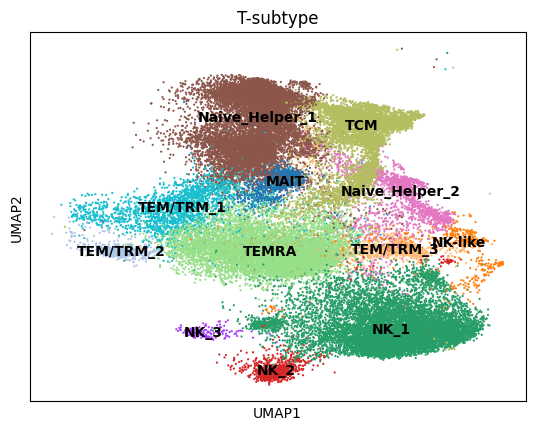

In [595]:
sc.pl.umap(adata[ (adata.obs.x<2.8)  ], color=['T-subtype'],legend_loc='on data',s=10,frameon=True)

In [597]:
adata[~adata.obs['T-subtype'].str.contains('NK_')]

View of AnnData object with n_obs × n_vars = 34785 × 31915
    obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype', 'batch'
    uns: 'T-subtype_colors'
    obsm: 'X_umap'

In [638]:
TCR_frq=sort_cnt(adata[~adata.obs['T-subtype'].str.contains('NK_')].obs.cdr3.to_list())

In [630]:
TCR_frq=sort_cnt(adata.obs.cdr3.to_list())

TCR_NK_frq=sort_cnt(adata[adata.obs['T-subtype'].str.contains('NK_')].obs.cdr3.to_list())

NK_only=set(TCR_NK_frq[0]) - set(TCR_frq[0])

TCR_NK_frq[TCR_NK_frq[0].isin(NK_only)]

In [639]:
TCR_frq=TCR_frq.iloc[1:]

In [641]:
#TCR_frq=TCR_frq.iloc[1:]
clone_size_map=dict(zip(TCR_frq[0],TCR_frq[1]))
adata.obs['Log10CloneSize']=np.log10(adata.obs.cdr3.apply(lambda x: clone_size_map[x] if x in clone_size_map else np.nan))

In [ ]:
sc.pl.umap(adata, color=['TRDC'],legend_loc='on data',s=10,frameon=True)

In [649]:
adata[ (adata.obs.x<2.8)  ].write('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/AML_DLI_TRB_all_final.h5ad',compression='gzip')

# Add PBMC of MS do stacked plot

In [149]:
adata=sc.read('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/AML_DLI_TRB_all_final.h5ad')
adata = adata[ (~adata.obs['T-subtype'].str.contains('NK_')) & (~adata.obs['Log10CloneSize'].isna()) & (adata.obs.y>-2.8) & (adata.obs.y<9.8) ].copy()
adata_MS = adata[adata.obs['patient']=='MS'].copy()
adata_MS.obs = adata_MS.obs[['patient','time','cdr3']]
adata_MS.obs.time.value_counts()

DLI     3280
POST     617
PRE      185
Name: time, dtype: int64

In [151]:
adata = sc.read_10x_h5('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run2/MS_101-1_47/outs/per_sample_outs/MS_101-1_47/count/sample_filtered_feature_bc_matrix.h5', gex_only=False)
adata.obs['time'] = 'PBMC'
adata.obs['patient'] = 'MS'
adata = adata[:,adata.var.feature_types=='Gene Expression'].copy()
adata.obs.index.name=  'barcode'
adata.var_names_make_unique()
contig = pd.read_csv('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/run2/MS_101-1_47/outs/per_sample_outs/MS_101-1_47/vdj_t/filtered_contig_annotations.csv')
IGHs = contig[contig.chain=='TRB']
mult = sort_cnt(IGHs.barcode)
IGHs = IGHs[IGHs.barcode.isin(mult[mult[1]==1][0])]
IGHs = IGHs[['barcode','cdr3']]
IGHs = IGHs.set_index('barcode')
adata.obs = adata.obs.merge(IGHs,on='barcode',how='left')
adata = adata[~adata.obs.cdr3.isna()].copy()

In [153]:
adata = adata.concatenate([adata_MS],join='inner')

/home/meb521/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [154]:
adata.obs.time.value_counts()

DLI     3280
POST     617
PBMC     249
PRE      185
Name: time, dtype: int64

In [156]:
TCR_frq = sort_cnt(adata.obs.cdr3.to_list())

clone_size_map = dict(zip(TCR_frq[0],TCR_frq[1]))
adata.obs['Log10CloneSize'] = np.log10(adata.obs.cdr3.apply(lambda x: clone_size_map[x] if x in clone_size_map else np.nan))

obs = adata.obs.copy()

shared = set(obs[obs.time=='PBMC'].cdr3) & set(obs[obs.time!='PBMC'].cdr3)

obs = obs[obs.cdr3.isin(shared)]

ff = sort_cnt(obs.cdr3)

select = ff[ff[1]>1]

In [157]:
colors = {'PRE': 'blue', 'POST': 'darkorange', 'DLI': 'green', 'PBMC': 'red'}

In [158]:
obs_sub=obs[(obs.cdr3.isin(select[0]))]
df_tcr=pd.crosstab(obs_sub.time,obs_sub.cdr3).T
times=df_tcr.columns.tolist()
times.reverse()
df_tcr['sum']=df_tcr.sum(axis=1)
df_tcr=df_tcr.sort_values('sum',ascending=False)
df_tcr=df_tcr[ (df_tcr['sum']<400) ] # to remove very the large MAIT clone

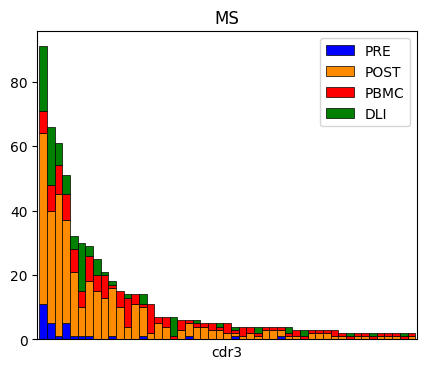

In [159]:
df_tcr=df_tcr[times]
plt.rcParams['figure.figsize'] = (df_tcr.shape[0]/10, 4)
df_tcr.plot(kind='bar',stacked=True,width=1, edgecolor='black', linewidth=.5,color=colors)
plt.xticks([]);
plt.legend(bbox_to_anchor=(1., 1.0));
plt.title('MS');
plt.savefig(f'MS_TCRs_BM_PBMC_new.pdf',bbox_inches='tight');

# TCR stacked graphs per patient

In [165]:
colors = {'PRE': 'blue', 'POST': 'darkorange', 'DLI': 'green', 'PBMC': 'red'}
adata=sc.read('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/AML_DLI_TRB_all_final.h5ad')
adata = adata[ (~adata.obs['T-subtype'].str.contains('NK_')) & (~adata.obs['Log10CloneSize'].isna()) & (adata.obs.y>-2.8) & (adata.obs.y<9.8) ].copy()
adata=adata[adata.obs.Log10CloneSize>0].copy()

In [166]:
obs=adata.obs.copy()

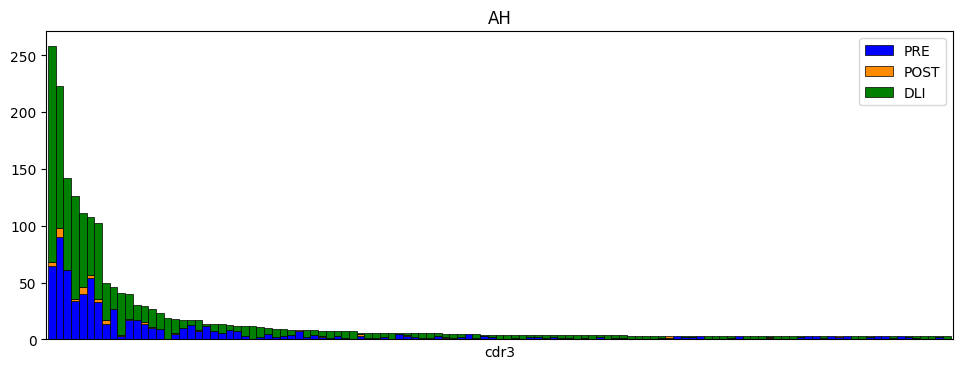

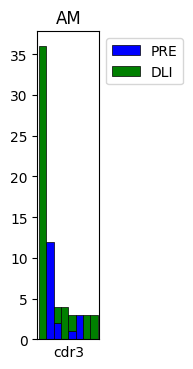

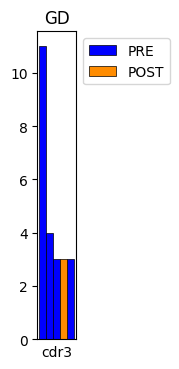

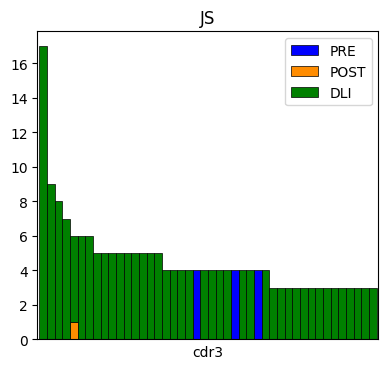

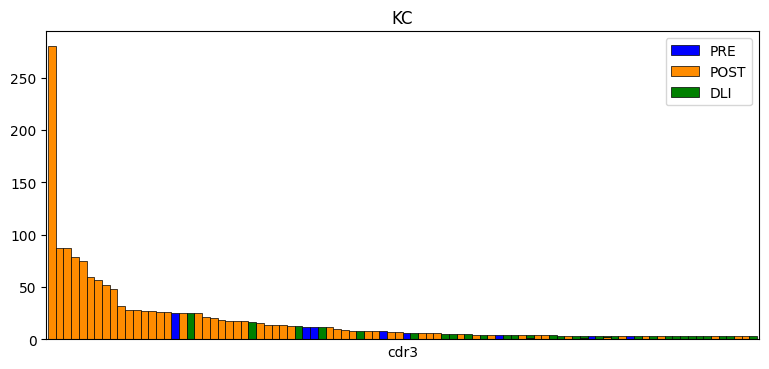

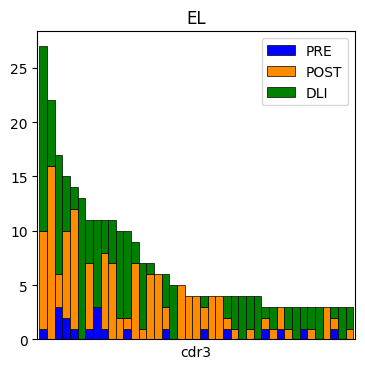

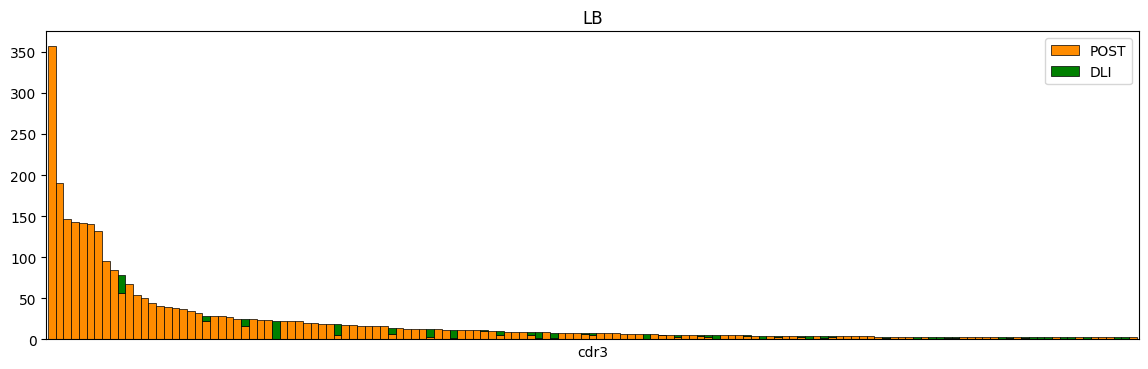

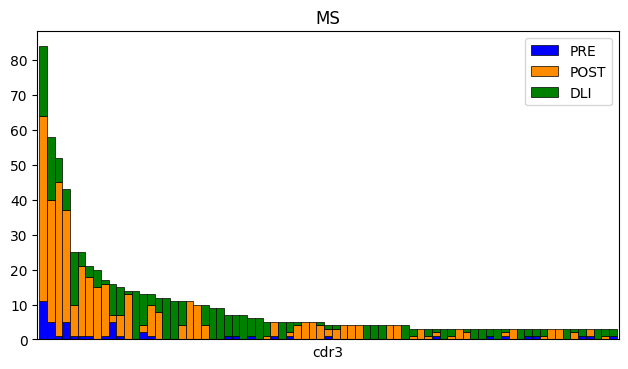

In [167]:
for patient in ['AH', 'AM', 'GD', 'JS', 'KC', 'EL','LB', 'MS']:

    ff=sort_cnt(obs[obs.patient==patient].cdr3)

    select=ff[ff[1]>2]
    obs_sub=obs[(obs.cdr3.isin(select[0])) & (obs.patient==patient)]
    df_tcr=pd.crosstab(obs_sub.time,obs_sub.cdr3).T
    
    times=df_tcr.columns.tolist()

    times.reverse()
    

    
    df_tcr['sum']=df_tcr.sum(axis=1)
    df_tcr=df_tcr.sort_values('sum',ascending=False)
    df_tcr=df_tcr[df_tcr['sum']<400]
    df_tcr=df_tcr[times]
    
    plt.rcParams['figure.figsize'] = (df_tcr.shape[0]/10, 4)
    df_tcr.plot(kind='bar',stacked=True,width=1, edgecolor='black', linewidth=.5,color=colors)
    plt.xticks([]);
    plt.legend(bbox_to_anchor=(1., 1.0));
    plt.title(patient);
    #ax.set_xticklabels(summary_prop.index, rotation=45);
    plt.savefig(f'{patient}_TCRs_stakced_final.pdf',bbox_inches='tight');

# UMAP plots for markers and clonality

In [322]:
adata=sc.read('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/AML_DLI_TRB_all_final.h5ad')

In [33]:
#[f[0] for f in np.array(adata[:,'TRDC'].X.todense()) if f>0]

In [34]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [35]:
adata.obs.y.min(),adata.obs.y.max()

(-6.6955, 10.510986)

In [323]:
adata = adata[ (~adata.obs['T-subtype'].str.contains('NK_')) & (~adata.obs['Log10CloneSize'].isna()) & (adata.obs.y>-2.8) & (adata.obs.y<9.8) ].copy()

In [324]:
time_map={'DLI':'DLI', 'PBMC':'PBMC', 'POST':'BM', 'PRE':'BM'}

In [325]:
adata.obs['site']=adata.obs['time'].apply(lambda x: time_map[x])

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata, color=['site'],s=5,alpha=.8,show=False,frameon=False)
#plt.savefig(f'Tcells_clusters_BM_DLI_final.pdf',bbox_inches='tight');

In [43]:
adata.obs['clusters'] = adata.obs['T-subtype'].astype('str').astype('category')

In [46]:
adata.obs.clusters.value_counts()

Naive_Helper_1    10568
TEMRA              7102
TCM                4715
TEM/TRM_1          1717
MAIT               1258
TEM/TRM_3           863
Naive_Helper_2      464
NK-like             240
TEM/TRM_2           232
Name: clusters, dtype: int64

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata, color=['clusters'],s=10,show=False,frameon=False)
plt.savefig(f'Tcells_clusters_final.pdf',bbox_inches='tight');
    

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata, color=['Log10CloneSize'],s=10,show=False,frameon=False)
plt.savefig(f'Tcells_clonesize_final.pdf',bbox_inches='tight');
    

In [327]:
adata[adata.obs.response=='RESPONDER']

View of AnnData object with n_obs × n_vars = 17721 × 31915
    obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype', 'batch', 'Log10CloneSize', 'site'
    uns: 'T-subtype_colors'
    obsm: 'X_umap'

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata[adata.obs.response=='RESPONDER'], color=['Log10CloneSize'],s=10,show=False,frameon=False)
plt.savefig(f'Tcells_clonesize_RESPONDER_final.pdf',bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata[ (adata.obs.response=='RESPONDER') & (adata.obs.site=='BM') ], color=['Log10CloneSize'],s=10,show=False,frameon=False)
plt.savefig(f'Tcells_clonesize_RESPONDER_BM_final.pdf',bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata[adata.obs.response=='NONRESPONDER'], color=['Log10CloneSize'],s=10,show=False,frameon=False)
plt.savefig(f'Tcells_clonesize_NONRESPONDER_final.pdf',bbox_inches='tight');
    

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata[ (adata.obs.response=='NONRESPONDER') & (adata.obs.site=='BM')], color=['Log10CloneSize'],s=10,show=False,frameon=False)
plt.savefig(f'Tcells_clonesize_NONRESPONDER_BM_final.pdf',bbox_inches='tight');
    

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata[ adata.obs.time=='DLI' ], color=['clusters'],s=10,show=False,frameon=False)
plt.savefig(f'./Tcells_clusters_DLI_final.pdf', bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata[ adata.obs.time=='DLI' ], color=['Log10CloneSize'],s=10,show=False,frameon=False)
plt.savefig(f'./Tcells_clonesize_DLI_final.pdf', bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata[  (adata.obs.time!='DLI')], color=['clusters'],s=10,show=False,frameon=False)
plt.savefig(f'./Tcells_clusters_BM_final.pdf',bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata[ adata.obs.time!='DLI' ], color=['Log10CloneSize'],s=10,show=False,frameon=False)
plt.savefig(f'./Tcells_clonesize_BM_final.pdf', bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
for gene in ['TIGIT','ZNF683','GZMB','GZMK','CX3CR1','FGFBP2']:
    sc.pl.umap(adata[ adata.obs.time!='DLI' ], color=[gene],s=10,legend_loc='on data',show=False,frameon=False)
    plt.savefig(f'BM_marker_{gene}_new.pdf',bbox_inches='tight');
    

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
for gene in ['TIGIT','ZNF683','GZMB','GZMK','CX3CR1','FGFBP2']:
    sc.pl.umap(adata[ adata.obs.time=='DLI' ], color=[gene],s=10,legend_loc='on data',show=False,frameon=False)
    plt.savefig(f'DLI_marker_{gene}.pdf',bbox_inches='tight');
    

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
for gene in ['TIGIT','ZNF683','GZMB','GZMK','CX3CR1','FGFBP2']:
    sc.pl.umap(adata, color=[gene],s=10,legend_loc='on data',show=False,frameon=False)
    plt.savefig(f'ALL_marker_{gene}_new.pdf',bbox_inches='tight');
    

# DEG vs Clonality

In [700]:
adata_sub=adata[adata.obs['T-subtype'].isin(['TEMRA', 'TEM/TRM_1'])].copy()

In [701]:
adata_sub.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata_sub, 'T-subtype', groups=['TEMRA'], reference='TEM/TRM_1', method='wilcoxon',key_added='TEMRA_TRM_DEG')

In [702]:
result = adata_sub.uns['TEMRA_TRM_DEG']
groups = result['names'].dtype.names
deg=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

In [703]:
deg=deg[deg.TEMRA_p<.001]

In [704]:
deg[deg.TEMRA_p<.001].to_csv('TEMRA_TRM_DEG_final.csv')

In [705]:
cln=adata_sub.obs.Log10CloneSize.to_list()

In [706]:
dense=np.array(adata_sub.X.todense())

In [707]:
adata_sub[adata_sub.obs.time!='DLI']

View of AnnData object with n_obs × n_vars = 6954 × 31915
    obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype', 'batch', 'Log10CloneSize'
    uns: 'T-subtype_colors', 'log1p', 'TEMRA_TRM_DEG'
    obsm: 'X_umap'

In [708]:
from tqdm import tqdm
from scipy import stats

In [722]:
add_res=[]
for gene in tqdm(deg['TEMRA_n']):
    dd=[s[0] for s in dense[:,adata_sub.var.index==gene]]
    res = stats.pearsonr(dd,cln)
    #print(gene,res)
    add_res.append([gene,res[0],res[1]])

100%|██████████| 1029/1029 [00:07<00:00, 137.43it/s]


In [723]:
corrs_cln=pd.DataFrame(add_res)

In [168]:
np.min(corrs_cln[corrs_cln[2]>0][2])

4.3095908844640295e-303

In [690]:
np.min(corrs_cln[corrs_cln[2]>0][2])

1.221857008080188e-306

In [162]:
#corrs_cln=corrs_cln[~corrs_cln[2].isna()]

In [724]:
from statsmodels.stats import multitest
fdr_pval=multitest.fdrcorrection(corrs_cln[2], alpha=0.01,is_sorted=False)[1]
new_pval=[]
min_p=np.min(fdr_pval[fdr_pval>0])
for p in fdr_pval:
    if p==0:
        new_pval.append(min_p)
    else:
        new_pval.append(p)
    
        
corrs_cln['-log10fdr']=-np.log10(new_pval)


In [725]:
corrs_cln['corr_abs']=np.abs(corrs_cln[1])

In [726]:
corrs_cln.to_csv('clone_corr_final.csv')

In [753]:
corr=pd.read_csv('clone_corr_final.csv',index_col=0)

In [754]:
corr

,0,1,2,-log10fdr,corr_abs
0,GZMH,0.458794,0.000000e+00,303.599534,0.458794
1,FGFBP2,0.481826,0.000000e+00,303.599534,0.481826
2,NKG7,0.469088,0.000000e+00,303.599534,0.469088
3,EFHD2,0.374288,1.810949e-291,288.507830,0.374288
4,GZMB,0.383237,1.221857e-306,303.599534,0.383237
...,...,...,...,...,...
1024,CD69,-0.257610,9.738611e-134,131.490449,0.257610
1025,DUSP1,-0.295694,1.590554e-177,175.087066,0.295694
1026,JUN,-0.285199,9.361616e-165,162.396445,0.285199
1027,LTB,-0.365404,7.079037e-277,274.040700,0.365404


In [755]:
corr.columns=['gene', 'Correlation', 'p-value', '-log10fdr','corr_abs']

In [756]:
deg=pd.read_csv('TEMRA_TRM_DEG_final.csv',index_col=0)

In [757]:
deg.columns=['gene', 'p-value', 'logFC']

In [758]:
tab=pd.merge(deg,corr,on='gene')

In [760]:
tab=tab[(tab['p-value_x']<.001) & (tab['p-value_y']<.001)].copy()

In [761]:
tab=tab.set_index('gene')

In [762]:
tab[['p-value_x', 'logFC', 'Correlation', 'p-value_y']].to_csv('Corr_DEG_final.csv')

In [764]:
tab=tab[(tab['Correlation']<-.1) | (tab['Correlation']>.1)]

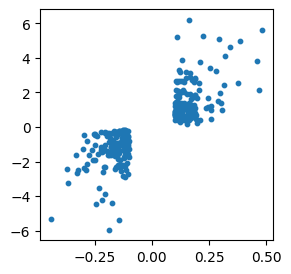

In [766]:
from adjustText import adjust_text
plt.rcParams['figure.figsize'] = (3, 3)
plt.scatter(x=tab['Correlation'],y=tab['logFC'],s=10,label="Not significant")

In [767]:
up_genes=['NKG7', 'GZMB',  'CD52','GNLY', 'PRF1', 'CX3CR1','ZNF683', 'FCGR3A']

In [768]:
down_genes=['IL7R', 'TIGIT','TCF7','CD27', 'CD28','CD69',  'LTB', 'GZMK']

In [774]:
#up_genes=['GZMH', 'NKG7', 'GZMB',  'CD52','GNLY', 'PRF1', 'CX3CR1','ZEB2', 'ZNF683', 'FCGR3A', 'TBX21']
#down_genes=['IL7R', 'XCL2','TIGIT','EOMES','TCF7','CD27', 'CD28','CD69',  'LTB', 'GZMK']

In [769]:
len(down_genes),len(up_genes)

(8, 8)

In [770]:
tab=tab[(tab['logFC']<=-1)|(tab['logFC']>=1)].copy()

In [771]:
tab=tab[(tab['Correlation']<=-.1)|(tab['Correlation']>=.1)].copy()

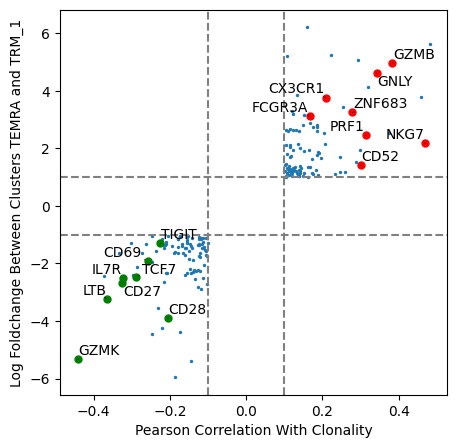

In [773]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.scatter(x=tab['Correlation'],y=tab['logFC'],s=2)

down = tab[(tab['logFC']<=-1)&(tab['Correlation']<=-.1)]
up = tab[(tab['logFC']>=1)&(tab['Correlation']>=0.1)]

down = tab.loc[down_genes]
up = tab.loc[up_genes]

plt.scatter(x=down['Correlation'],y=down['logFC'],s=25,label="Downregulated",color="green")
plt.scatter(x=up['Correlation'],y=up['logFC'],s=25,label="Upregulated",color="red")

texts=[]
for i,r in up.iterrows():
    texts.append(plt.text(y=r['logFC'],x=r['Correlation'],s=i))
    
for i,r in down.iterrows():
    texts.append(plt.text(y=r['logFC'],x=r['Correlation'],s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xlabel("Pearson Correlation With Clonality")
plt.ylabel("Log Foldchange Between Clusters TEMRA and TRM_1")
plt.axvline(-.1,color="grey",linestyle="--")
plt.axvline(.1,color="grey",linestyle="--")
plt.axhline(-1,color="grey",linestyle="--")
plt.axhline(1,color="grey",linestyle="--")
#plt.legend()
plt.savefig(f'Corr_DEG_final.pdf',bbox_inches='tight');

# genesets

In [2]:
#adata=sc.read('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/AML_DLI_PERI_TRB_allcell_clustered_15pc.h5ad')
adata=sc.read('AML_DLI_TRB_all_final.h5ad')


In [3]:
adata.obs.patient

barcode
AAACCTGAGGATTCGG-1-0     LB
AAACCTGAGTCCTCCT-1-0     LB
AAACCTGCACCCAGTG-1-0     JS
AAACCTGCAGTTCATG-1-0     LB
AAACCTGCATCAGTCA-1-0     JS
                         ..
TTTGTCATCAAAGTAG-1-13    AH
TTTGTCATCCGATATG-1-13    AH
TTTGTCATCGAGAACG-1-13    AH
TTTGTCATCGCACTCT-1-13    AH
TTTGTCATCTTGGGTA-1-13    AH
Name: patient, Length: 45402, dtype: category
Categories (8, object): ['AH', 'AM', 'EL', 'GD', 'JS', 'KC', 'LB', 'MS']

In [4]:
adata = adata[ (~adata.obs['T-subtype'].str.contains('NK_')) & (~adata.obs['Log10CloneSize'].isna()) & (adata.obs.y>-2.8) & (adata.obs.y<9.8) ].copy()

In [5]:
time_map={'DLI':'DLI', 'PBMC':'PBMC', 'POST':'BM', 'PRE':'BM'}

In [6]:
adata.obs['site']=adata.obs['time'].apply(lambda x: time_map[x])

In [7]:
sc.pp.normalize_total(adata, target_sum=1e6)

In [8]:
genes_giac=pd.read_csv('giacomo.csv')

In [9]:
virus_cd8=genes_giac[~genes_giac['gene.1'].isna()]['gene.1'].tolist()

In [10]:
tumor_cd8=genes_giac[~genes_giac['gene'].isna()]['gene'].tolist()

In [11]:
tumor_cd4=genes_giac[~genes_giac['gene.2'].isna()]['gene.2'].tolist()

In [12]:
exps=adata[:,tumor_cd4].X.sum(axis=1).tolist()
exps=np.array([f[0] for f in exps])
adata.obs['tumor_cd4']=exps

In [13]:
exps = adata[:,tumor_cd8].X.sum(axis=1).tolist()
exps = np.array([f[0] for f in exps])
adata.obs['tumor_cd8'] = exps

In [14]:
exps = adata[:,virus_cd8].X.sum(axis=1).tolist()
exps = np.array([f[0] for f in exps])
adata.obs['virus_cd8'] = exps

In [15]:
adata.obs['log10_TPM_Tumor_CD4'] = np.log10(adata.obs.tumor_cd4+1)
adata.obs['log10_TPM_Tumor_CD8'] = np.log10(adata.obs.tumor_cd8+1)
adata.obs['log10_TPM_Virus_CD8'] = np.log10(adata.obs.virus_cd8+1)

barcode
AAACCTGAGTCCTCCT-1-0     9.999999e+05
AAACCTGCATGCTAGT-1-0     9.999999e+05
AAACCTGGTCTCTCGT-1-0     1.000000e+06
AAACCTGGTGATGTCT-1-0     1.000000e+06
AAACCTGGTTCTGAAC-1-0     1.000000e+06
                             ...     
TTTGTCACAGACAAAT-1-13    9.999999e+05
TTTGTCACAGATAATG-1-13    9.999999e+05
TTTGTCATCAAAGTAG-1-13    1.000000e+06
TTTGTCATCGAGAACG-1-13    1.000000e+06
TTTGTCATCGCACTCT-1-13    1.000000e+06
Name: n_counts, Length: 27159, dtype: float32

In [16]:
sc.pp.filter_cells(adata, min_counts=100)

adata.obs['log10_tumor_cd4_fraction'] = np.log10(adata.obs.tumor_cd4/adata.obs.n_counts+1)
adata.obs['log10_tumor_cd8_fraction'] = np.log10(adata.obs.tumor_cd8/adata.obs.n_counts+1)
adata.obs['log10_virus_cd8_fraction'] = np.log10(adata.obs.virus_cd8/adata.obs.n_counts+1)

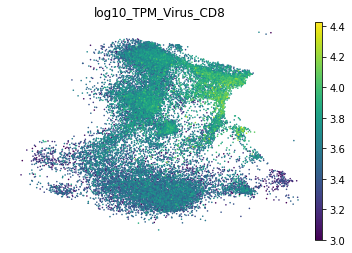

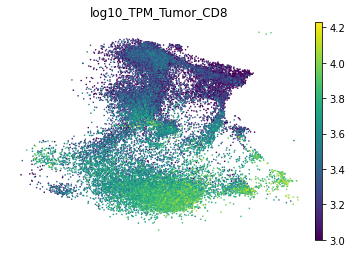

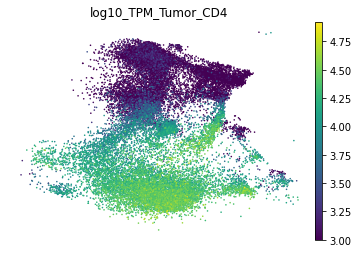

In [17]:
for var in ['log10_TPM_Virus_CD8','log10_TPM_Tumor_CD8','log10_TPM_Tumor_CD4']:
    sc.pl.umap(adata, color=var, s=10, legend_loc='on data', show=False,frameon=False,vmin=3)#,cmap='plasma')
#     plt.savefig(f'{var}_Giacomo.pdf',bbox_inches='tight');

In [ ]:
obs_cd8=adata2[~adata2.obs['sample'].isna()].obs

In [ ]:
adata3=adata2[~adata2.obs['sample'].isna()].copy()

In [ ]:
from scipy.stats import ranksums

In [122]:
adata.obs['T-subtype'].value_counts()

Naive_Helper_1    10568
TEMRA              7102
TCM                4715
TEM/TRM_1          1717
MAIT               1258
TEM/TRM_3           863
Naive_Helper_2      464
NK-like             240
TEM/TRM_2           232
Name: T-subtype, dtype: int64

In [139]:
adata[(adata.obs['T-subtype']=='TEMRA') & (adata.obs['time']!='DLI') ]

View of AnnData object with n_obs × n_vars = 6126 × 31915
    obs: 'x', 'y', 'cluster_number', 'patient', 'response', 'sample', 'time', 'cdr3', 'T-subtype', 'batch', 'Log10CloneSize', 'site', 'tumor_cd4', 'tumor_cd8', 'virus_cd8', 'log10_TPM_Tumor_CD4', 'log10_TPM_Tumor_CD8', 'log10_TPM_Virus_CD8', 'n_counts', 'log10_tumor_cd4_fraction', 'log10_tumor_cd8_fraction', 'log10_virus_cd8_fraction'
    uns: 'T-subtype_colors'
    obsm: 'X_umap'

In [125]:
x = adata.obs[(adata.obs['T-subtype']=='TEMRA') & (adata.obs['time']!='DLI') ] ['log10_TPM_Tumor_CD8']
y = adata.obs[(adata.obs['T-subtype']=='TEM/TRM_1') & (adata.obs['time']!='DLI') ] ['log10_TPM_Tumor_CD8']

print(ranksums(x, y))
print(np.median(x),np.median(y))

RanksumsResult(statistic=16.398125352339896, pvalue=1.9723086356862243e-60)
3.6727333407367477 3.545841022889431


In [ ]:
plt.rcParams['figure.figsize'] = (4, 5)
sc.pl.violin(adata[(adata.obs['T-subtype']=='TEMRA') & (adata.obs['log10_TPM_Tumor_CD8']>3) & (adata.obs['time']=='DLI') ], 'log10_TPM_Tumor_CD8',s=30, groupby='response',show=False)
plt.savefig(f'log10_TPM_Tumor_CD8_response_DLI_TEMRA.pdf',bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (4, 5)
sc.pl.violin(adata[(adata.obs['T-subtype']=='TEMRA') & (adata.obs['log10_TPM_Tumor_CD8']>3) & (adata.obs['time']!='DLI') ], 'log10_TPM_Tumor_CD8',s=30, groupby='response',show=False)
plt.savefig(f'log10_TPM_Tumor_CD8_response_BM_TEMRA.pdf',bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (4, 5)
sc.pl.violin(adata[(adata.obs['T-subtype']=='TEMRA') & (adata.obs['log10_TPM_Tumor_CD8']>3) ], 'log10_TPM_Tumor_CD8',s=30, groupby='response',show=False)
plt.savefig(f'log10_TPM_Tumor_CD8_response_ALL_TEMRA.pdf',bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (8, 4)
sc.pl.violin(adata[ (adata.obs['log10_TPM_Tumor_CD8']>0) & (adata.obs['time']!='DLI') ], 'log10_TPM_Tumor_CD8',s=30, groupby='T-subtype',show=False,rotation=90)
plt.savefig(f'log10_TPM_Tumor_CD8_BM.pdf',bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (8, 4)
sc.pl.violin(adata[ (adata.obs['log10_TPM_Tumor_CD8']>0) & (adata.obs['time']=='DLI') ], 'log10_TPM_Tumor_CD8',s=30, groupby='T-subtype',show=False,rotation=90)
plt.savefig(f'log10_TPM_Tumor_CD8_DLI.pdf',bbox_inches='tight');

In [ ]:
plt.rcParams['figure.figsize'] = (8, 4)
sc.pl.violin(adata[ (adata.obs['log10_TPM_Tumor_CD8']>0) ], 'log10_TPM_Tumor_CD8',s=30, groupby='T-subtype',show=False,rotation=90)
plt.savefig(f'log10_TPM_Tumor_CD8_ALL.pdf',bbox_inches='tight');

In [44]:
x= [0.0, 0.0, 0.0,.0,.0,0]
y= [0.9, 0.9, 0.9,.9,.9,1]
print(ranksums(x, y,alternative='less'))
print(wilcoxon(x, y,alternative='less'))

RanksumsResult(statistic=-2.8823067684915684, pvalue=0.0019738759284517286)
WilcoxonResult(statistic=0.0, pvalue=0.015625)


# vdjdb

In [193]:
adata=sc.read('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/AML_DLI_TRB_all_final.h5ad')

In [194]:
adata = adata[ (~adata.obs['T-subtype'].str.contains('NK_')) & (~adata.obs['Log10CloneSize'].isna()) & (adata.obs.y>-2.8) & (adata.obs.y<9.8) ].copy()

In [195]:
time_map={'DLI':'DLI', 'PBMC':'PBMC', 'POST':'BM', 'PRE':'BM'}

In [196]:
adata.obs['site']=adata.obs['time'].apply(lambda x: time_map[x])

In [197]:
vdj=pd.read_table('vdjdb-2023-04-26.tsv.gz')

In [198]:
dd= list (set(vdj.CDR3) & set(adata.obs.cdr3))

In [199]:
subvdj=vdj[vdj.CDR3.isin(dd)][['CDR3','Epitope species']]

In [200]:
cdr_epi=dict(zip(subvdj['CDR3'],subvdj['Epitope species']))

In [201]:
adata.obs['VDJdb']=adata.obs.cdr3.isin(dd)*1

In [202]:
adata.obs['epitope']=adata.obs.cdr3.apply(lambda x: cdr_epi[x] if x in cdr_epi.keys() else 'NA')

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata, color=['VDJdb'],s=30,show=False,frameon=False)
plt.savefig(f'VDJdb_sharing.pdf',bbox_inches='tight');

In [205]:
allowed_vals=['CMV', 'EBV', 'InfluenzaA']

In [206]:
adata.obs.loc[~adata.obs['epitope'].isin(allowed_vals), 'epitope'] = 'NA'

In [207]:
adata.obs['epitope']=adata.obs['epitope'].replace('NA', np.nan)
adata.obs['epitope']=adata.obs['epitope'].astype('category')

In [208]:
adata.obs['epitope']=adata.obs['epitope'].cat.remove_unused_categories()

In [209]:
#color_map=, 'PBMC': 'red'
colors = {'CMV': 'blue', 'EBV': 'yellow', 'InfluenzaA': 'red'}

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata, color=['epitope'],s=80,show=False,frameon=False,palette=colors)
plt.savefig(f'VDJdb_epitope.pdf',bbox_inches='tight');

In [270]:
adata.obs['Epitope_CDR3'] = adata.obs.cdr3.astype('str') + '_' + adata.obs.epitope.astype('str')

In [271]:
select_clones = adata[ (adata.obs.Log10CloneSize>.5) & (~adata.obs.epitope.isna())].obs['Epitope_CDR3'].value_counts().index

In [272]:
adata.obs.loc[~adata.obs['Epitope_CDR3'].isin(select_clones), 'Epitope_CDR3'] = 'NA'

In [273]:
adata.obs.Epitope_CDR3.value_counts()

NA                      26949
CASSRTSGPYNEQFF_CMV       108
CASSPISNEQFF_CMV           41
CASSSYRENTGELFF_CMV        27
CASSLAQGTDTQYF_CMV         13
CASSDDGMNTEAFF_EBV          5
CASSLTGSEQYF_CMV            4
CASSLTDPYEQYF_EBV           4
CASSLGRNTEAFF_CMV           4
CASSLIGVSSYNEQFF_CMV        4
Name: Epitope_CDR3, dtype: int64

In [274]:
adata.obs['Epitope_CDR3']=adata.obs['Epitope_CDR3'].replace('NA', np.nan)
adata.obs['Epitope_CDR3']=adata.obs['Epitope_CDR3'].astype('category')

In [276]:
 adata.obs['Epitope_CDR3'].cat.categories=adata.obs.Epitope_CDR3.value_counts().index.tolist()

In [ ]:
plt.rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata, color=['Epitope_CDR3'],s=80,show=False,frameon=False)
plt.savefig(f'VDJdb_Epitope_CDR3_TOP.pdf',bbox_inches='tight');

# pycircos

In [278]:
adata=sc.read('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/AML_DLI_TRB_all_final.h5ad')

In [279]:
adata = adata[ (~adata.obs['T-subtype'].str.contains('NK_')) & (~adata.obs['Log10CloneSize'].isna()) & (adata.obs.y>-2.8) & (adata.obs.y<9.8) ].copy()

In [280]:
time_map={'DLI':'DLI', 'PBMC':'PBMC', 'POST':'BM', 'PRE':'BM'}

In [281]:
adata.obs['site']=adata.obs['time'].apply(lambda x: time_map[x])

In [283]:
adata.obs=adata.obs[['sample', 'time', 'response', 'cluster_number', 'cdr3', 'patient','T-subtype', 'batch','Log10CloneSize']]

In [284]:
obs=adata.obs

In [286]:
obs=obs[obs.Log10CloneSize>0].copy()

In [288]:
obs.to_csv('TCR_total_2p_new.csv')

In [289]:
cols="""1f77b4 #1f77b4
aec7e8 #aec7e8
ff7f0e #ff7f0e
ffbb78 #ffbb78
2ca02c #2ca02c
98df8a #98df8a
d62728 #d62728
ff9896 #ff9896
9467bd #9467bd
c5b0d5 #c5b0d5
8c564b #8c564b
c49c94 #c49c94
e377c2 #e377c2
f7b6d2 #f7b6d2
7f7f7f #7f7f7f
c7c7c7 #c7c7c7
bcbd22 #bcbd22
dbdb8d #dbdb8d
17becf #17becf
9edae5 #9edae5"""

cols=cols.split('\n')
cols=[c[7:] for c in cols]
cols=cols*100

In [290]:
import random

import pycircos
import matplotlib.pyplot as plt
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle
import pandas as pd
from colormap import hex2rgb
from colormap import rgb2hex

In [291]:
#obs=pd.read_csv('TCR_total_2p.csv')

In [292]:
obs=pd.read_csv('TCR_total_2p_new.csv')

In [293]:
import matplotlib.pylab as plt
cmap = plt.cm.gist_rainbow  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]

In [294]:
three100=cmaplist

In [295]:
cols=[]
for c in three100:
    cols.append(rgb2hex(c[0],c[1],c[2],c[3]))
    

In [297]:
obs['T-subtype']

0        TEMRA
1        TEMRA
2        TEMRA
3        TEMRA
4        TEMRA
         ...  
11105      TCM
11106      TCM
11107      TCM
11108    TEMRA
11109      TCM
Name: T-subtype, Length: 11110, dtype: object

In [298]:
all_clust=obs['T-subtype'].value_counts()
print(sorted(all_clust.index))

['MAIT', 'NK-like', 'Naive_Helper_1', 'Naive_Helper_2', 'TCM', 'TEM/TRM_1', 'TEM/TRM_2', 'TEM/TRM_3', 'TEMRA']


In [299]:
all_clust

TEMRA             6582
TEM/TRM_1         1013
TCM                978
MAIT               776
TEM/TRM_3          647
Naive_Helper_1     620
TEM/TRM_2          200
Naive_Helper_2     155
NK-like            139
Name: T-subtype, dtype: int64

In [333]:
all_colors={'TEMRA':'#2278b5', 'TEM/TRM_1':'#d3d827', 'TCM':'#8d574c', 'MAIT':'#2fa148', 'TEM/TRM_3':'#f7ae1a', 'Naive_Helper_1':'#7f7f7f', 'TEM/TRM_2':'#78489d',
       'Naive_Helper_2':'#f47b29', 'NK-like':'#8d574c'}

#all_colors={'0.0_BM':'#2278b5', '4_DLI':'#2278b5', '10_DLI':'#8d574c', '7.0_BM':'#2fa148', '2_DLI':'#f7ae1a', '45.0_BM':'#7f7f7f', '19.0_BM':'#78489d',
#       '3.0_BM':'#f47b29', '31.0_BM':'#8d574c', '1_DLI':'#d3d827', '6_DLI':'#e26d6d', '37.0_BM':'#d87ab2', '8_DLI':'#ad88be', '17.0_BM':'#d62a28'}


In [337]:
res = 'NONRESPONDER'

In [346]:
res = 'RESPONDER'

In [354]:
n_seed=1234

In [359]:
obs=pd.read_csv('TCR_total_2p_new.csv')
obs=obs[obs.time!='PBMC'].copy()

tab_s=obs[ (obs.response==res)  ]
cnts=pd.crosstab(tab_s.cdr3,tab_s.time)

tab_s=tab_s[['time','T-subtype','cdr3']].copy()

times=tab_s.time.unique()

per_time_dfs=[]
for t in times:
    
    sub=tab_s[tab_s.time==t].copy()
    sub.set_index('cdr3',inplace=True)
    
    cdr_count=sort_cnt(sub.index)
    cdr_count.set_index(0,inplace=True)
    
    tcr_cluster_map={}
    
    for cdr in cdr_count.index:
        reps=cdr_count.loc[cdr][1]
        if reps==1:
            #print(cdr)
            tcr_cluster_map[cdr]=sub.loc[cdr]['T-subtype']
        else:
            #if reps>20:print(cdr,reps)
            tcr_cluster_map[cdr]=sub.loc[cdr]['T-subtype'].value_counts().index[0]
        
    sub.reset_index(inplace=True)
    
    sub['time_class_majority']=sub.cdr3.apply(lambda x: tcr_cluster_map[x])
    
    per_time_dfs.append(sub)

tab_s=pd.concat(per_time_dfs)

tab_s['cdr_class'] =tab_s['time_class_majority']+ '_' +tab_s['cdr3']

#tab_s=tab_s.sort_values(by=['time','cdr_class','DLI_BM_Integrated']) # to put CDR3s together

tab_s=tab_s.sort_values(by=['time','time_class_majority','cdr3']) # to put CDR3s together

In [ ]:
tab_s.to_csv('ff.csv')

tab_s.cdr3.value_counts()

tab_s[tab_s.cdr3=='CASSIVGEETGELFF']

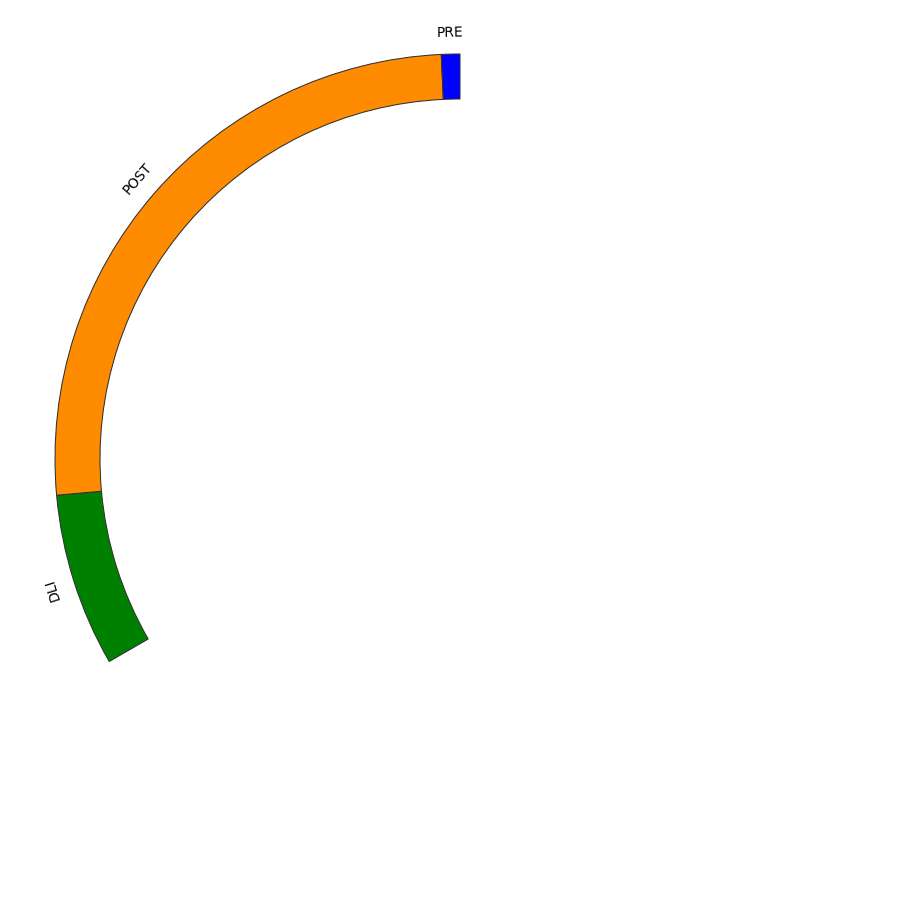

In [360]:
#tab_s.to_csv('cdr_class_majo.csv')

#tab_s=tab_s.sort_values(by=['time','cdr3','DLI_BM_Integrated']) # to put CDR3s together

#tab_s=tab_s.sort_values(by=['time','DLI_BM_Integrated','cdr3'])# to put clusters together

tab_s['cells']=1
tab_s['cells_end']=tab_s['cells'].cumsum()
tab_s['cells_start']=tab_s['cells_end']-1
#tab_s['clust_cdr']=tab_s['DLI_BM_Integrated']+'_'+tab_s['cdr3'] # old on clusters only
tab_s['clust_cdr']=tab_s['time_class_majority']+'_'+tab_s['cdr3']
#tab_s.tail(40)

ll=tab_s.drop_duplicates(subset='time',keep='last').copy()
ll_s=tab_s.drop_duplicates(subset='time',keep='first').copy()

ll['cells_start']=ll_s['cells_start'].to_list()
ll['width']=ll['cells_end']-ll['cells_start']
ll=ll.set_index('time')
ll.loc['DLI'].width

colors = {'PRE': 'blue', 'POST': 'darkorange', 'DLI': 'green', 'PBMC': 'red'}

diam=800
circle = Gcircle(figsize=(9,9)) 
for t in ll.index:
    
    name   = t
    length = ll.loc[t].width
    arc    = Garc(arc_id=name, size=length, interspace=0, raxis_range=(diam,diam+100), facecolor=colors[t], labelposition=100, label_visible=True)
    circle.add_garc(arc) 

circle.set_garcs(-120,0)

In [361]:
#tab_s['clust_cdr']=tab_s['time']+'_'+tab_s['DLI_BM_Integrated']+'_'+tab_s['cdr3'] old based on real clust
tab_s['clust_cdr']=tab_s['time']+'_'+tab_s['time_class_majority']+'_'+tab_s['cdr3']
tab_s['cells']=1
tab_s['cells_end']=tab_s['cells'].cumsum()
tab_s['cells_start']=tab_s['cells_end']-1
#tab_s.tail(40)
ll=tab_s.drop_duplicates(subset='clust_cdr',keep='last').copy()
ll_s=tab_s.drop_duplicates(subset='clust_cdr',keep='first')
ll['cells_start']=ll_s['cells_start'].to_list()
ll['width']=ll['cells_end']-ll['cells_start']

ll=ll.set_index('time')

#ll['color']=ll.DLI_BM_Integrated.apply(lambda x: all_colors[x])

ll['color']=ll.time_class_majority.apply(lambda x: all_colors[x])
times=ll.index.unique()

import collections
arcdata_dict = collections.defaultdict(dict)

for time in times:
    print(time)
    ll_c=ll.loc[time].copy()
    ll_c['cells_start']=ll_c['cells_start']-ll_c.iloc[0].cells_start
    
    #ll_c=ll_c[ll_c.width>2].copy()

    arcdata_dict[time]["positions"] = ll_c.loc[time]['cells_start'].to_list()
    arcdata_dict[time]["widths"]    = ll_c.loc[time]['width'].to_list()
    arcdata_dict[time]["colors"]    = ll_c.loc[time]['color'].to_list()

for key in arcdata_dict:
    circle.barplot(key, data=[1]*len(arcdata_dict[key]["positions"]), positions=arcdata_dict[key]["positions"], 
                   width=arcdata_dict[key]["widths"], raxis_range=[diam-80,diam], facecolor=arcdata_dict[key]["colors"])    

tab_s['clust_cdr']=tab_s['time']+'_'+tab_s['cdr3']
tab_s['cells']=1
tab_s['cells_end']=tab_s['cells'].cumsum()
tab_s['cells_start']=tab_s['cells_end']-1
#tab_s.tail(40)
ll=tab_s.drop_duplicates(subset='clust_cdr',keep='last').copy()
ll_s=tab_s.drop_duplicates(subset='clust_cdr',keep='first').copy()
ll['cells_start']=ll_s['cells_start'].to_list()
ll['width']=ll['cells_end']-ll['cells_start']
ll=ll.set_index('time')
time_tcr_dic=collections.defaultdict(dict)
for time in times:
    print(time)
    ll_c=ll.loc[time].copy()
    diff=ll_c.iloc[0].cells_start
    ll_c['cells_start']=ll_c['cells_start']-diff
    
    ll_c['cells_end']=ll_c['cells_end']-diff
    
    ll_c=ll_c.set_index('cdr3')

    ll_c=ll_c[['cells_end','cells_start','width']].copy()

    #ll_c=ll_c[ll_c.width>5].copy()
    time_tcr_dic[time]=ll_c

cnn=cnts.copy()

nonzero=[]
for tcr in cnn.index:
    av_times=cnn.loc[tcr][['DLI','POST','PRE']]
    nonzero.append(len(av_times[av_times>0].index.to_list()))

cnn['rep_times']=nonzero

cnn=cnn[cnn.rep_times>1].copy()

random.seed(n_seed)
print(f'numTCR={len(cnn)}')
cnn['color']=random.sample(cols,len(cnn))
#cnn['color']= cols[:len(cnn)]

diam=diam-80

DLI
POST
PRE
DLI
POST
PRE
numTCR=185


In [351]:
time_tcr_dic['DLI'].loc['CASSIVGEETGELFF']

cells_end      525
cells_start     61
width          464
Name: CASSIVGEETGELFF, dtype: int64

In [309]:
#time_tcr_dic['DLI'].loc['CASSIVGEETGELFF']

In [311]:
#time_tcr_dic['PRE'].loc['CASSIVGEETGELFF']

In [344]:
av_times

['DLI', 'POST', 'PRE']

In [362]:
res

'RESPONDER'

In [363]:
for tcr in cnn.index:

    av_times=cnn.loc[tcr][['DLI','POST','PRE']]
    
    rgb=hex2rgb(cnn.loc[tcr]['color'])

    facecolor=(rgb[0]/256,rgb[1]/256,rgb[2]/256,.1)

    av_times=av_times[av_times>0].index.to_list()
    
    if len(av_times)==2:
        
        source = (av_times[0], time_tcr_dic[av_times[0]].loc[tcr].cells_start, time_tcr_dic[av_times[0]].loc[tcr].cells_end, diam)
        destination = (av_times[1], time_tcr_dic[av_times[1]].loc[tcr].cells_start, time_tcr_dic[av_times[1]].loc[tcr].cells_end, diam)
        
        if 'DLI' in av_times and 'PRE' in av_times:
            circle.chord_plot(source, destination, facecolor=facecolor)
        else:
            circle.chord_plot(source, destination, facecolor=cnn.loc[tcr]['color'])
        
    if len(av_times)==3:
        
        source = ('PRE', time_tcr_dic['PRE'].loc[tcr].cells_start, time_tcr_dic['PRE'].loc[tcr].cells_end, diam)
        destination = ('DLI', time_tcr_dic['DLI'].loc[tcr].cells_start, time_tcr_dic['DLI'].loc[tcr].cells_end, diam)
        #circle.chord_plot(source, destination, facecolor=cnn.loc[tcr]['color'])
        circle.chord_plot(source, destination, facecolor=facecolor)
        
        source = ('DLI', time_tcr_dic['DLI'].loc[tcr].cells_start, time_tcr_dic['DLI'].loc[tcr].cells_end, diam)
        destination = ('POST', time_tcr_dic['POST'].loc[tcr].cells_start, time_tcr_dic['POST'].loc[tcr].cells_end, diam)
        circle.chord_plot(source, destination, facecolor=cnn.loc[tcr]['color'],linewidth=.0)
        
        source = ('PRE', time_tcr_dic['PRE'].loc[tcr].cells_start, time_tcr_dic['PRE'].loc[tcr].cells_end, diam)
        destination = ('POST', time_tcr_dic['POST'].loc[tcr].cells_start, time_tcr_dic['POST'].loc[tcr].cells_end, diam)
        circle.chord_plot(source, destination, facecolor=cnn.loc[tcr]['color'],linewidth=.0)
#circle.figure    
circle.figure.savefig(f'{res}_circos_{n_seed}_final_newcolor_trans_.1_lowdeg.pdf')

# venn diagrams

In [184]:
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted

In [169]:
adata=sc.read('/n/data2/dfci/medonc/cwu/meb521/singlecell/AML_DLI/AML_DLI_TRB_all_final.h5ad')

In [170]:
adata = adata[ (~adata.obs['T-subtype'].str.contains('NK_')) & (~adata.obs['Log10CloneSize'].isna()) & (adata.obs.y>-2.8) & (adata.obs.y<9.8) ].copy()

In [171]:
tem=pd.crosstab(obs['patient'],obs['time'])

In [118]:
tem

time,DLI,POST,PRE
patient,,,
AH,4804,19,1007
AM,1390,0,147
EL,2331,321,46
GD,0,70,732
JS,1765,30,2
KC,3151,986,628
LB,913,2211,82
MS,3699,232,183


In [173]:
res_map=adata.obs.drop_duplicates('patient')

In [174]:
res_map=dict(zip(res_map['patient'],res_map['response']))

In [175]:
res_map

{'LB': 'RESPONDER',
 'EL': 'RESPONDER',
 'JS': 'NONRESPONDER',
 'GD': 'NONRESPONDER',
 'AH': 'NONRESPONDER',
 'KC': 'RESPONDER',
 'AM': 'NONRESPONDER',
 'MS': 'RESPONDER'}

In [176]:
tem=tem.reset_index()

In [177]:
tem['response']=tem['patient'].apply(lambda x: res_map[x])

In [178]:
tem=tem.sort_values(by='response')

AH 138 28 215
AM 20 0 20


/home/meb521/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")


GD 28 8 0


/home/meb521/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


JS 5 5 99
EL 27 48 102
KC 13 83 135
LB 0 240 99


/home/meb521/miniconda3/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


MS 34 89 154


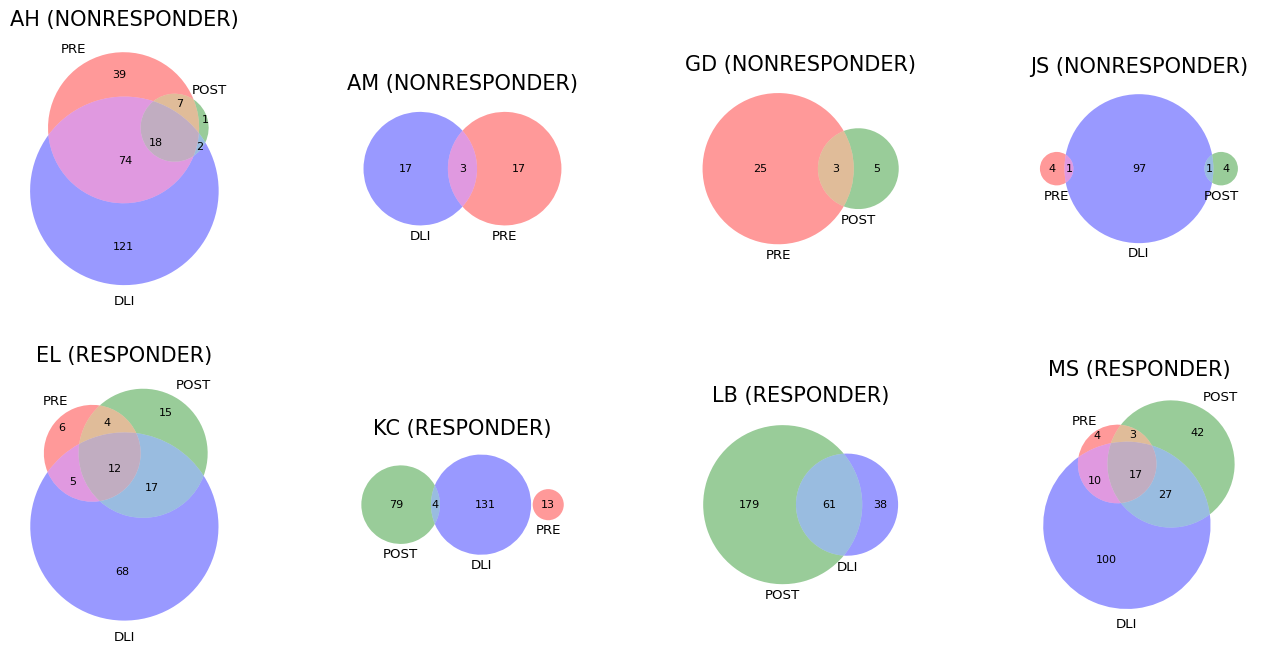

In [182]:
nrow=2;ncol=4;wd=4
fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*wd,nrow*wd), gridspec_kw={'wspace':.5})
axr=ax.ravel()

for i,p in enumerate(tem.patient):

    tab_s=obs[obs['patient']==p][['time','cdr3']]
    res=tem[tem['patient']==p].response.to_list()[0]

    tcr_cnt=sort_cnt(tab_s[tab_s['time']=='PRE'].cdr3)
    tcr_cnt.columns=['cdr3','count']
    tcr_cnt['frac']=tcr_cnt['count']/tcr_cnt['count'].sum()
    tcr_pre=tcr_cnt.copy()
    pre=len(set(tcr_pre['cdr3']))

    tcr_cnt=sort_cnt(tab_s[tab_s['time']=='POST'].cdr3)
    tcr_cnt.columns=['cdr3','count']
    tcr_cnt['frac']=tcr_cnt['count']/tcr_cnt['count'].sum()
    tcr_post=tcr_cnt.copy()
    post=len(set(tcr_post['cdr3']))
    
    tcr_cnt=sort_cnt(tab_s[tab_s['time']=='DLI'].cdr3)
    tcr_cnt.columns=['cdr3','count']
    tcr_cnt['frac']=tcr_cnt['count']/tcr_cnt['count'].sum()
    tcr_DLI=tcr_cnt.copy()
    DLI=len(set(tcr_DLI['cdr3']))
    
    pre_post_DLI = len(set(tcr_pre['cdr3']) & set(tcr_post['cdr3']) & set(tcr_DLI['cdr3']) )
    pre_post =     len(set(tcr_pre['cdr3']) & set(tcr_post['cdr3']))
    pre_DLI =      len(set(tcr_pre['cdr3']) & set(tcr_DLI['cdr3']))
    post_DLI =     len(set(tcr_post['cdr3']) & set(tcr_DLI['cdr3']))

    print(p,pre , post , DLI)
    
    if pre==0:l1=''
    else: l1='PRE'
    
    if post==0:l2=''
    else: l2='POST'
    
    if DLI==0:l3=''
    else: l3='DLI'
    
    #font2 =  # use for labels
    plt.rc('font',**{'size': 8}) # sets the default font 
    venn3(subsets = (pre-(pre_post+pre_DLI-pre_post_DLI), 
                     post-(pre_post+post_DLI-pre_post_DLI), 
                     pre_post-pre_post_DLI,
                     DLI-(post_DLI+pre_DLI-pre_post_DLI), 
                     pre_DLI-pre_post_DLI, 
                     post_DLI-pre_post_DLI, 
                     pre_post_DLI), set_labels = (l1, l2,l3), ax=axr[i])
    axr[i].set_title(f'{p} ({res})', fontsize=15)
    
    #font1 = {'family':'serif','color':'black','size':16} # use for title
    #font2 = {'family': 'Comic Sans MS', 'size': 5} # use for labels
    #plt.rc('font', **font2) # sets the default font 
    plt.rcParams['text.color'] = 'black' # changes default text colour
    plt.savefig(f'./venns_final.pdf',bbox_inches='tight');

AH 138 28 215
AM 20 0 20
GD 28 8 0
JS 5 5 99
EL 27 48 102
KC 13 83 135
LB 0 240 99
MS 34 89 154


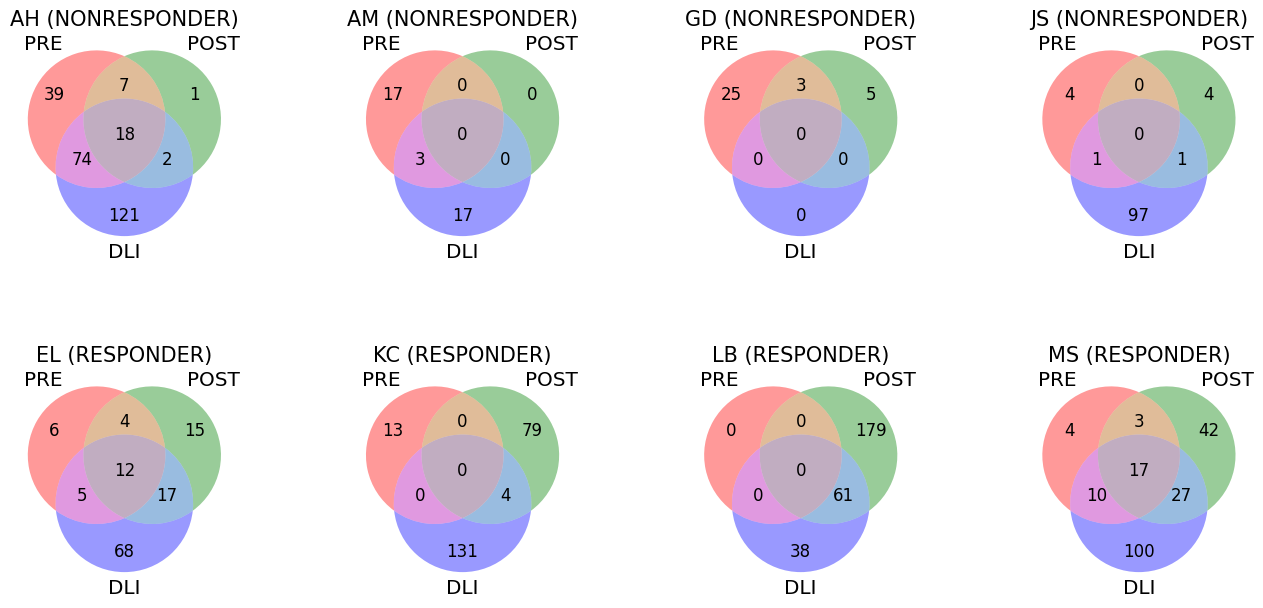

In [186]:
nrow=2;ncol=4;wd=4
fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*wd,nrow*wd), gridspec_kw={'wspace':.5})
axr=ax.ravel()

for i,p in enumerate(tem.patient):

    #tab_s=obs_sub[obs_sub['patient']==p][['time','cdr3']]
    tab_s=obs[obs['patient']==p][['time','cdr3']]
    res=tem[tem['patient']==p].response.to_list()[0]
    

    tcr_cnt=sort_cnt(tab_s[tab_s['time']=='PRE'].cdr3)
    tcr_cnt.columns=['cdr3','count']
    tcr_cnt['frac']=tcr_cnt['count']/tcr_cnt['count'].sum()
    tcr_pre=tcr_cnt.copy()
    pre=len(set(tcr_pre['cdr3']))

    tcr_cnt=sort_cnt(tab_s[tab_s['time']=='POST'].cdr3)
    tcr_cnt.columns=['cdr3','count']
    tcr_cnt['frac']=tcr_cnt['count']/tcr_cnt['count'].sum()
    tcr_post=tcr_cnt.copy()
    post=len(set(tcr_post['cdr3']))

    tcr_cnt=sort_cnt(tab_s[tab_s['time']=='DLI'].cdr3)
    tcr_cnt.columns=['cdr3','count']
    tcr_cnt['frac']=tcr_cnt['count']/tcr_cnt['count'].sum()
    tcr_DLI=tcr_cnt.copy()
    DLI=len(set(tcr_DLI['cdr3']))

    pre_post_DLI = len(set(tcr_pre['cdr3']) & set(tcr_post['cdr3']) & set(tcr_DLI['cdr3']) )
    pre_post =     len(set(tcr_pre['cdr3']) & set(tcr_post['cdr3']))
    pre_DLI =      len(set(tcr_pre['cdr3']) & set(tcr_DLI['cdr3']))
    post_DLI =     len(set(tcr_post['cdr3']) & set(tcr_DLI['cdr3']))

    print(p,pre , post , DLI)

    if pre<-1:l1=''
    else: l1='PRE'

    if post<-1:l2=''
    else: l2='POST'

    if DLI<-1:l3=''
    else: l3='DLI'

    #font2 =  # use for labels
    plt.rc('font',**{'size': 12}) # sets the default font 
    venn3_unweighted([set(tcr_pre['cdr3']),set(tcr_post['cdr3']),set(tcr_DLI['cdr3'])], set_labels = (l1, l2,l3), ax=axr[i])
    axr[i].set_title(f'{p} ({res})', fontsize=15)

    #font1 = {'family':'serif','color':'black','size':16} # use for title
    #font2 = {'family': 'Comic Sans MS', 'size': 5} # use for labels
    #plt.rc('font', **font2) # sets the default font 
    #plt.rcParams['text.color'] = 'black' # changes default text colour

plt.savefig(f'./venns_unweighted.pdf',bbox_inches='tight');